In [1]:
import torch
from torch import nn
from typing import Dict, List, Tuple
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.Resize(256), # new
    transforms.CenterCrop(224),  # new
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),  # Randomly changes the scale and aspect ratio
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=0.2),  # Random erase
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
  
    return train_loss, train_acc

In [5]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              num_classes: int) -> Tuple[float, float, List[float]]:
    # Put model in eval mode
    model.eval() 

    # Setup test loss, test accuracy, and class-wise accuracy values
    test_loss, correct_predictions, total_samples = 0, 0, 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate correct predictions
            test_pred_labels = test_pred_logits.argmax(dim=1)
            correct_predictions += (test_pred_labels == y).sum().item()

            # Accumulate total number of samples
            total_samples += len(y)

            # Calculate class-wise accuracy
            for t, p in zip(y, test_pred_labels):
                class_correct[t] += int(t == p)
                class_total[t] += 1

    # Calculate average test loss
    test_loss = test_loss / len(dataloader)

    # Calculate test accuracy
    test_acc = correct_predictions / total_samples

    # Calculate class-wise accuracy
    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0 for i in range(num_classes)]

    return test_loss, test_acc, class_acc

In [6]:
def calculate_class_accuracy(preds, targets, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, target in zip(preds, targets):
        class_correct[target] += (pred == target).item()
        class_total[target] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(num_classes)]
    return class_accuracy



In [7]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
                f=model_save_path)

In [8]:
import os

# Define path to your dataset
current_path = os.getcwd()
# print(currect_path)
dataset_subpath = 'D:/Segmentation And Classification/Output/Bot Beer Datasets/train_dataset'
dataset_path = os.path.join(current_path, dataset_subpath)

In [9]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
dataset = ImageFolder(root=dataset_path)

In [10]:
# Splitting the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset)) # 80%
validation_size = len(dataset) - train_size # 20%
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

In [11]:
# Get transforms
train_dataset.dataset.transform = train_transforms
print(train_dataset.dataset.transform)

validation_dataset.dataset.transform = transform
print(validation_dataset.dataset.transform)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [12]:
# Creating data loaders
BATCH_SIZE = 16
print(f"Batch Size: {BATCH_SIZE}")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Batch Size: 16


In [13]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "class_acc": []  # Store class-wise accuracy
              }
    
    num_classes = len(train_dataloader.dataset.dataset.classes)  # Access classes from the original dataset
    
    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        
        test_loss, test_acc, class_acc = test_step(model=model,
                                                    dataloader=test_dataloader,
                                                    loss_fn=loss_fn,
                                                    device=device,
                                                    num_classes=num_classes)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["class_acc"].append(class_acc)
        
    # Plotting the training and testing accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["test_acc"], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Testing Accuracy")
    plt.legend()
    plt.show()

    # Print classification report
    all_preds, all_targets = [], []
    model.eval()
    with torch.no_grad():
        for data in test_dataloader:
            inputs, targets = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_targets, all_preds))

    # Return the filled results at the end of the epochs
    return results,all_preds,all_targets

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
model = models.resnet50(weights='DEFAULT')
for parameter in model.parameters(): 
    parameter.requires_grad = False # Freezing Layers
num_features = model.fc.in_features
num_classes = 2
model.summary() #Trainable parameters will be 0
"""
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),   # Increase the number of hidden units
    nn.ReLU(),                      # ReLU activation
    nn.Dropout(0.5),                # ReLU activation
    nn.Linear(1024, 512),            # Additional layer
    nn.ReLU(),                      # ReLU activation
    nn.Dropout(0.5),                # ReLU activation
    nn.Linear(512, 256),            # Additional layer
    nn.ReLU(),                      # ReLU activation
    nn.Linear(256, num_classes)     # Output layer
)
"""
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 1 | train_loss: 0.6218 | train_acc: 0.6595 | test_loss: 0.5543 | test_acc: 0.7266
Epoch: 2 | train_loss: 0.5271 | train_acc: 0.7480 | test_loss: 0.3948 | test_acc: 0.8255
Epoch: 3 | train_loss: 0.4664 | train_acc: 0.7871 | test_loss: 0.3669 | test_acc: 0.8385
Epoch: 4 | train_loss: 0.4245 | train_acc: 0.7943 | test_loss: 0.3821 | test_acc: 0.8411
Epoch: 5 | train_loss: 0.3666 | train_acc: 0.8385 | test_loss: 0.3094 | test_acc: 0.8464
Epoch: 6 | train_loss: 0.3451 | train_acc: 0.8542 | test_loss: 0.3321 | test_acc: 0.8490
Epoch: 7 | train_loss: 0.3038 | train_acc: 0.8652 | test_loss: 0.3237 | test_acc: 0.8698
Epoch: 8 | train_loss: 0.3219 | train_acc: 0.8620 | test_loss: 0.3659 | test_acc: 0.8411
Epoch: 9 | train_loss: 0.2744 | train_acc: 0.8776 | test_loss: 0.2659 | test_acc: 0.8698
Epoch: 10 | train_loss: 0.2574 | train_acc: 0.8926 | test_loss: 0.2903 | test_acc: 0.8776
Epoch: 11 | train_loss: 0.2388 | train_acc: 0.8926 | test_loss: 0.3012 | test_acc: 0.8594
Epoch: 12 | train_l

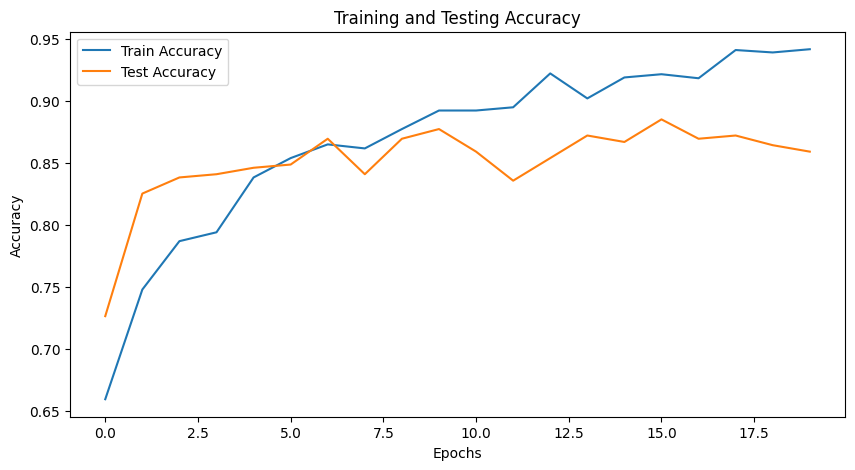

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       192
           1       0.84      0.89      0.86       192

    accuracy                           0.86       384
   macro avg       0.86      0.86      0.86       384
weighted avg       0.86      0.86      0.86       384



In [18]:
epochs = 20
results, all_preds, all_targets = train(model=model,
                train_dataloader=train_loader,
                test_dataloader=validation_loader,
                optimizer=optimizer,
                loss_fn=criterion,
                epochs=epochs,
                device=device)
